# Min-Hashing und LSH mit Map-Reduce
Für uns war es einfacher den Plan nicht nur theoretisch zu schreiben, sondern auch direkt einzlene Komponenten in 
Code umzusetzen, um genau zu Verstehen wie die einzelnen Schritte funktionieren (bzw. ob und wie man dann weiter machen kann). So sind die Code Zellen eine gute Hilfe dann später die Map-Reduce Jobs zu schreiben.

# 1 Laden der Daten (Mapper)
Wir Laden die Daten aus dem Chunk Zeile für Zeile aus der Datei und speichern alle Texte in einer Liste für später. Wir haben uns hier dazu entschieden die Whitespaces nicht zu entfernen, da die Texte so oder so schon sehr kurz sind.

**Das könnte in etwa so im Code umgesetzt werden**

In [180]:
import numpy as np
import scipy.sparse as sp

In [181]:
# lese alle Texte aus dem Chunk
texts = []
with open('sts2016-english-with-gs-v1.0/STS2016.input.answer-answer.txt', 'r') as f:
    for line in f:
        elements = line.strip().split('\t')
        texts.append(elements[0].replace('\n', ''))
        texts.append(elements[1])
        
for i in range(5):
    print(texts[i])

Tasting it is the only reliable way.
The way you have it is fine.
I think it probably depends on your money.
It depends on your country.
You need to read a lot to know what you like and what you don't.


# 2 Erstellen der k-shingles (Mapper)
Hier erstellen wir für jeden Text eine Menge von Shingles der Länge k. Diese Mengen speichern wir auch in einer Liste, so kann jeder Mapper für sich in unserem Fall nachvollziehen, welches Shingle zu welchem Text gehört.

**Das könnte in etwa so im Code umgesetzt werden**

In [182]:
# erstelle für jeden Text eine Menge von Shingles der Länge k
shingles_per_text = []
k = 3
for text in texts:
    shingles_per_text.append(set([text[i:i + k] for i in range(len(text) - k + 1)]))

# 3 Erstelle für jede Menge von Shingles einen Bit-Vektor (Mapper)
Nun möchten wir jede Menge von Shingels in einen Bit-Vektor umformen, sodass wir später die Min-Hashes berechnen können. Hier haben wir in Map-Reduce das Problem, dass wir das Universum nicht kennen/es nicht in den Speicher passt. An dieser Stelle können wir die Shingels hashen. Solange wir genügnend Buckets beim Hashing verwenden, hat jedes Shingle einen eindeutigen Hash-Value (Wenn man zufällige Hash-Kollisionen ignoriert. *Diese sind aber auch nicht schlimm, da wir durch Kollisionen nur falsch Positive erhalten*).
Da dieser Vector sehr Sparse ist, können wir ihn in einer für solche Zwecke optimierten Datenstrucktur speichern. So haben wir mit der Hash-Funktion ein Universum simuliert und alle Bit-Vectoren auf die gleiche Länge gebracht für jeden Mapper.

**Das könnte in etwa so im Code umgesetzt werden**

In [183]:
universum_dimension = 5000000
bit_matrix = []

for shingle_set in shingles_per_text:
    indices = []
    for shingle in shingle_set:
        hash_value = hash(shingle) % universum_dimension
        indices.append(hash_value)
    # Data array filled with ones, same length as indices (for scipy)
    data = [1] * len(indices)
    # Since each shingle set is independent, indptr just starts at 0 and ends at the length of indices (for scipy)
    indptr = [0, len(indices)]
    # Construct the sparse vector
    sparse_vector = sp.csr_matrix((data, indices, indptr), shape=(1, universum_dimension))
    bit_matrix.append(sparse_vector)
    
# Print the first sparse vector
for i in range(1):
    print(bit_matrix[i])

  (0, 4531013)	1
  (0, 1884614)	1
  (0, 1811527)	1
  (0, 2722827)	1
  (0, 4954700)	1
  (0, 1481296)	1
  (0, 1012950)	1
  (0, 3917146)	1
  (0, 3193822)	1
  (0, 4774560)	1
  (0, 1346785)	1
  (0, 1320738)	1
  (0, 635235)	1
  (0, 3235492)	1
  (0, 706151)	1
  (0, 992042)	1
  (0, 209005)	1
  (0, 1490034)	1
  (0, 462579)	1
  (0, 371510)	1
  (0, 2123576)	1
  (0, 4051514)	1
  (0, 2908093)	1
  (0, 4575553)	1
  (0, 1255745)	1
  (0, 110547)	1
  (0, 3712405)	1
  (0, 265883)	1
  (0, 3405602)	1
  (0, 1522852)	1
  (0, 166246)	1
  (0, 4819177)	1
  (0, 4124969)	1
  (0, 1227837)	1


# 4 Berechne die Min-Hashes (Mapper)
Nun kann der Mapper aus der Matrix der Signaturen die Min-Hash Signaturen berechnen.

**Das könnte in etwa so im Code umgesetzt werden**

In [184]:
# erstelle die hash-funktionen
num_hash_functions = 500
hash_functions = []
for h in range(num_hash_functions):
    a = np.random.randint(1, num_hash_functions * 100)
    b = np.random.randint(1, num_hash_functions * 100)
    # check if the hash function is already in the list
    while (a, b) in hash_functions:
        a = np.random.randint(1, 1000000)
        b = np.random.randint(1, 1000000)
    hash_functions.append((a, b))

In [185]:
# berechne die Min-Hashes, für jede hash-funktion
from sympy import nextprime
p = nextprime(universum_dimension * 10)
minhash_signatures = []
for vector in bit_matrix:
    signature = []
    for  a, b in hash_functions:
        # berechne den minhash für die aktuelle hash-funktion
        minhash = np.inf
        for index in vector.indices:
            minhash = min(minhash, (a * index + b) % p) % universum_dimension
        signature.append(minhash)
        
    minhash_signatures.append(signature)

In [186]:
for i in range(5):
    print(minhash_signatures[i][:10])

[753226, 160096, 710873, 719685, 586472, 103637, 647061, 1606443, 655100, 543490]
[596219, 836824, 1246461, 1129520, 1548318, 1183407, 35895, 1086999, 437754, 2987636]
[801481, 977273, 156669, 427973, 417193, 103637, 281409, 2317197, 1618453, 1767034]
[801481, 1931779, 946302, 406628, 1168467, 839500, 281409, 662925, 1854218, 2135914]
[138116, 118222, 184785, 612072, 7627, 146793, 281409, 119578, 45588, 473035]


# 5 Nutze nun LSH und finde die Kandidatenpaare (Mapper)
Jetzt können wir mithilfe der Min-Hash Signatuen LSH verwenden, um die Kandidatenpaare zu finden. Dazu müssen wir die Min-Hash Signaturen in Bänder aufteilen und dann die Bänder in Buckets sortieren. Die Buckets sind dann die Kandidatenpaare.

**Das könnte in etwa so im Code umgesetzt werden**

In [187]:
def sort_bands_into_buckets(number_of_buckets=10000000, number_bands=64, number_rows_per_band=len(hash_functions) / 64):
    buckets = dict()
    # hier entspricht der col_index der text id und so kann der text später wieder gefunden werden
    for col_index in range(len(minhash_signatures)):
        for band_num in range(number_bands):
            # betrachte den signature vector für die aktuelle text id
            signature_vector = minhash_signatures[col_index]
            
            # erstelle das Band
            start_index = int(band_num * number_rows_per_band)
            end_index = int((band_num + 1) * number_rows_per_band)
            band = signature_vector[start_index:end_index]
            
            # berechne den hash wert für das band
            bucket_index = hash(str(band)) % number_of_buckets
            
            # füge den index des textes und den text in den Bucket hinzu
            buckets[bucket_index] = buckets.get(bucket_index, []) + [(col_index, texts[col_index])]
            
    return buckets
       

## 5.1 Ausgeben der Buckets an die Reducer

An dieser Stelle können wir Buckets, die 2 oder mehr Elemente haben an die Reducer übergeben. Wir wählen als key den "bucket index", welcher einfach gemeinsame Hash-Wert aller Elemente im Bucket ist. Als value übergeben wir hier den Bucket, also die Liste der Elemente im Bucket.


**In anderen Fällen würden wir hier nicht immer den Text in den Buckets speichern, da hierdurch potentiel große Mengen von Daten zwischen Mappern und Reducern getauscht werden. In anderen Anwendungen wäre es besser eine Text/Doc id zu bestimmen, das müsste man dann aber vorher verwalten.**

In [188]:
buckets = sort_bands_into_buckets()

# 6 Finde die Kandidatenpaare (Reducer)
Da jeder Reducer einen Bucket mit mehreren Elementen bekommt, kann er nun die Kandidatenpaare finden. Dazu müssen wir nur alle Paare in einem Bucket finden und zurückgeben. Im code werden hier zwar die Tupel mit Text ausgegeben. Im Map-Reduce ist es aber sinnvoller folgendes auszugeben: key=(id1, id2), value=(text1,text2). Hierbei entfernen wir sofort duplikate durch die Wahl des Schlüssels, wenn mehrere Reducer die gleichen Paare finden. Auch ist hier wieder anzumerken, dass es in hinsicht auf eine Optimierung auch besser ist als Value nicht den Text zu speichern, sondern eine Text/Doc id. So können wir die Datenmenge die zwischen Mappern und Reducern getauscht wird minimieren.

In [189]:
def find_candidate_pairs(buckets):    
    candidate_pairs = set()
    for bucket in buckets.values():
        for i in range(len(bucket)):
            for j in range(i + 1, len(bucket)):
                candidate_pairs.add((bucket[i], bucket[j]))
    return candidate_pairs

In [190]:
candidate_pairs = find_candidate_pairs(buckets)

In [191]:
# print the first 10 candidate pairs
for i, pair in enumerate(candidate_pairs):
    if i == 5:
        break
    print(pair)

((776, 'There are a few things you can do: '), (1258, 'There are a few things you can do: '))
((1515, "I don't think that there's any."), (1916, "I don't think that there's any."))
((592, 'It depends on what you want to do next, and where you want to do it.'), (668, 'It depends on what you want to do next, and where you want to do it.'))
((1702, "It depends on how it's used."), (1884, "It depends on how it's used."))
((230, 'It depends on what they are.'), (1558, 'It depends on what you want to do next, and where you want to do it.'))


# Bonus: Berechnen der Jaccard Similarity für die Paare

In [192]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [193]:
# erstelle einen DF mit den Paaren
df = pd.DataFrame({'id1': [pair[0][0] for pair in candidate_pairs],
                   'text1': [pair[0][1] for pair in candidate_pairs],
                   'id2': [pair[1][0] for pair in candidate_pairs],
                   'text2': [pair[1][1] for pair in candidate_pairs]})

In [194]:
def get_jaccard_sim(id1, id2):
    # finde die shingles für die beiden texte
    shingles1 = shingles_per_text[id1]
    shingles2 = shingles_per_text[id2]
    
    # berechne die Jaccard Similarity
    return len(shingles1.intersection(shingles2)) / len(shingles1.union(shingles2))

In [195]:
df['jaccard_sim'] = df.apply(lambda row: get_jaccard_sim(row['id1'], row['id2']), axis=1)

In [196]:
df

,id1,text1,id2,text2,jaccard_sim
0,776,There are a few things you can do:,1258,There are a few things you can do:,1.000000
1,1515,I don't think that there's any.,1916,I don't think that there's any.,1.000000
2,592,"It depends on what you want to do next, and wh...",668,"It depends on what you want to do next, and wh...",1.000000
3,1702,It depends on how it's used.,1884,It depends on how it's used.,1.000000
4,230,It depends on what they are.,1558,"It depends on what you want to do next, and wh...",0.305085
...,...,...,...,...,...
15377,96,You should do it.,2810,You should do it.,1.000000
15378,834,All of the answers above are good.,2074,Do you have to wait?,0.020833
15379,2323,They just don't want you to know it.,2555,They just don't want you to know it.,1.000000
15380,328,You just have to base your answer on what you ...,2032,You just have to base your answer on what you ...,1.000000


In [197]:
print(f'Anzahl der Kandidatenpaare: {len(df)}')
print(f'Anzahl der Kandidatenpaare mit Jaccard Similarity 1: {len(df[df["jaccard_sim"] == 1])}')
print(f'Anzahl der Kandidatenpaare mit Jaccard Similarity 0: {len(df[df["jaccard_sim"] == 0])}')
print(f'Durchschnittliche Jaccard Similarity: {df["jaccard_sim"].mean()}')

Anzahl der Kandidatenpaare: 15382
Anzahl der Kandidatenpaare mit Jaccard Similarity 1: 8838
Anzahl der Kandidatenpaare mit Jaccard Similarity 0: 557
Durchschnittliche Jaccard Similarity: 0.6945414365318491


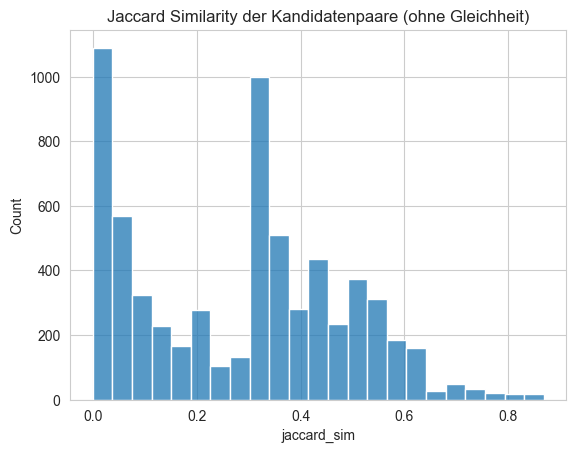

In [198]:
# plot die Jaccard Similarity ohne Gleichheit
sns.histplot(df[df['jaccard_sim'] != 1]['jaccard_sim'])
plt.title('Jaccard Similarity der Kandidatenpaare (ohne Gleichheit)')
plt.show()

# Schlusswort
Hier sind die Hyperparemeter in keinster Weise optimiert, dennoch war es für die generellen Überlegungen hilfreich das LSH zuerst ohne Map-Reduce zu verwenden um zu prüfen, dass die Ideen umsetzbar sind. Man kann natürlich auch an vielen Stellen für Map-Reduce auch weiter Optimieren, das würde dann aber den Rahmen der Aufgabe sprengen.